# Twitter Disaster Tweet Classifier with DistilBERT

The purpose of this model is to determine whether a given Tweet is about a real diaster (war, flood, famine, etc.) or benign. For example, the Tweet "the sky looks beutifully ablaze tonight" likelly does not refer to a real fire. 

## Visualize the Dataset

### Load Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Load and Format

In [2]:
# Read from CSV
dataset = pd.read_csv("./data/train.csv")

# Drop (potentially) unnecessary columns. These may be useful, but I'm not quite ready to work with missing data.
dataset = dataset.drop(["id", "keyword", "location"], axis=1)
dataset.head(20)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
5,#RockyFire Update => California Hwy. 20 closed...,1
6,#flood #disaster Heavy rain causes flash flood...,1
7,I'm on top of the hill and I can see a fire in...,1
8,There's an emergency evacuation happening now ...,1
9,I'm afraid that the tornado is coming to our a...,1


### Visualize

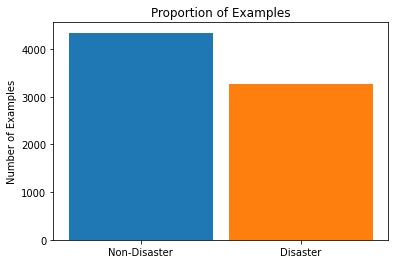

In [3]:
# Get the count of each label. Posative indicates that the tweet is about a disaster.
posative_count = dataset[dataset["target"] == 1].shape[0]
negative_count = dataset[dataset["target"] == 0].shape[0]

plt.bar("Non-Disaster",negative_count,0.9, label="Non-Disaster")
plt.bar("Disaster",posative_count,0.9, label="Disaster")
plt.ylabel('Number of Examples')
plt.title('Proportion of Examples')
plt.show()

## Fine-Tune Pretrained Model for Inference 

Below, I use the HuggingFace `transformers` library to fine-tune DistilBERT on the tweets dataset. 

### Load Imports

In [4]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset, Dataset
import torch

/home/kyle/miniconda3/envs/disaster-tweet-classifier-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Create Dataset

In [5]:
# Init tokenizer for converting text to numbers
model_path = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_path)

# In order to add padding on a batch-level rather than a dataset level, add dynamic padding using a data 
# collator. This will add padding to the maximum input in a batch rather than the entire 
# data set which saves computation. 
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Read data from CSV, embed, and split into test and train
raw_dataset = Dataset.from_pandas(dataset)
raw_dataset = raw_dataset.rename_column("target", "labels")
raw_dataset = raw_dataset.map(lambda example: tokenizer(example["text"]), batched=True)
raw_dataset = raw_dataset.with_format("torch")
formatted_datasets = raw_dataset.train_test_split(0.2)

# Show Output
formatted_datasets

Parameter 'function'=<function <lambda> at 0x7f3944ee9090> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
100%|██████████| 8/8 [00:00<00:00, 41.18ba/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 6090
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1523
    })
})

### Configure Trainer

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)
model.to(device)

print(f"Running on Device Type: {device.type}")

training_arguments = TrainingArguments("test-trainer")
trainer = Trainer(
    model,
    training_arguments,
    train_dataset=formatted_datasets["train"],
    eval_dataset=formatted_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)


Running on Device Type: cpu


### Execute the Training/Fine-Tuning Run

In [8]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 6090
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2286


Step,Training Loss
500,0.466400
1000,0.375000
1500,0.298700
2000,0.180700


Saving model checkpoint to test-trainer/checkpoint-500
Configuration saved in test-trainer/checkpoint-500/config.json
Model weights saved in test-trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-500/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1000
Configuration saved in test-trainer/checkpoint-1000/config.json
Model weights saved in test-trainer/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1500
Configuration saved in test-trainer/checkpoint-1500/config.json
Model weights saved in test-trainer/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1500/tokenizer_config.json
Special tokens file saved

TrainOutput(global_step=2286, training_loss=0.3134070235391719, metrics={'train_runtime': 1265.2212, 'train_samples_per_second': 14.44, 'train_steps_per_second': 1.807, 'total_flos': 241778357635224.0, 'train_loss': 0.3134070235391719, 'epoch': 3.0})